# Industrial Copper Sales - Data Extraction and Analysis

In [1]:
# importing important modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
copp = pd.read_excel('Copper_Set.xlsx', sheet_name=0)

# Approach:

## 1. Data Understanding

* Identify the types of variables
* Understand the data distribution
* Change datatypes when and where necessary

In [3]:
# data info:
# first few rows of dataset:
copp.head(2)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.0
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.8,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.0


In [4]:
# shape of the dataset:
print(copp.shape)
print(f"\nThe dataset has {copp.shape[0]} rows and {copp.shape[1]} columns")

(181673, 14)

The dataset has 181673 rows and 14 columns


In [5]:
copp.describe()

,item_date,customer,country,application,thickness,width,product_ref,delivery date,selling_price
count,1.816720e+05,1.816720e+05,181645.000000,181649.000000,181672.000000,181673.000000,1.816730e+05,1.816720e+05,1.816720e+05
mean,2.020459e+07,3.051221e+07,44.893022,25.615809,2.564827,1295.286724,4.739679e+08,2.020738e+07,1.918036e+03
std,4.551119e+03,2.433382e+07,24.404214,17.754175,6.572321,261.631754,7.175101e+08,2.411059e+04,3.317956e+05
min,1.995000e+07,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,2.019040e+07,-1.160000e+03
25%,2.020093e+07,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2.020110e+07,6.690000e+02
50%,2.020113e+07,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2.021010e+07,8.120000e+02
75%,2.021020e+07,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2.021040e+07,9.530000e+02
max,2.021040e+07,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,3.031010e+07,1.000010e+08


### Inferences:
The inferences from this analysis are listed as points:

* Firstly, the 'material_ref' field has the most number of nulls present in the dataset
* Secondly, the 'selling_price' field has values starting from negative 1160 which would prove a negative sales.

In [6]:
# datatype understanding
copp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [7]:
# verify the unique items in every features

for i in list(copp.columns):
    print(f"{i} : {copp[i].nunique()}")

id : 181671
item_date : 252
quantity tons : 181673
customer : 1169
country : 17
status : 9
item type : 7
application : 30
thickness : 594
width : 1386
material_ref : 16563
product_ref : 33
delivery date : 28
selling_price : 9795


### Inference:
The variables of country, status and item type seem to be objects with less subcategories which can be classified as categorical variables useful for our prediction.

In [8]:
# data modifications as per requirement:
# looking at the data it looks like we need to make some datatype modifications:

columns_to_convert_numeric = ["quantity tons", "customer", "country", "application", "thickness", "width", "selling_price"]
copp[columns_to_convert_numeric] = copp[columns_to_convert_numeric].apply(pd.to_numeric, errors="coerce")

columns_to_convert_datetime = ['item_date', 'delivery date']
for i in columns_to_convert_datetime:
    copp[i] = pd.to_datetime(copp[i], format='%Y%m%d', errors='coerce').dt.date

In [9]:
copp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181670 non-null  object 
 2   quantity tons  181672 non-null  float64
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181670 non-null  object 
 13  selling_price  181672 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 19.4+ MB


In [10]:
# material ref column: remove values with 0000
copp.loc[copp['material_ref'].str.contains(r'0{10,}', na=False), 'material_ref'] = np.nan

In [11]:
copp.head(2)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.8,1210.0,NaN,1668701718,2021-04-01,1047.0


In [12]:
# id is an unrequired column, so we are dropping it:
copp = copp.drop(['id'],axis=1)

## Data Processing with EDA

### Missing values treatment

Using mean, median, or mode to fill NA (missing) values in a dataset depends on the nature of the data and the distribution of the values. 

* Mean: Suitable for filling missing values in numerical data that is symmetrically distributed (i.e., normally distributed) and when the mean is representative of the data.
* Median: Useful when the data has outliers or is skewed. The median is a robust measure of central tendency and is not affected by extreme values.
* Mode: Appropriate for categorical data or when the most frequent value is the best representation of the missing values.

#### Missing value treatment for the dataset: 
* Some columns like **quantity tons, thickness, selling_price** are continuous in nature, so we can use **mean** here.
* From an earlier code, we have seen that the **country, application and status** are categorical with few to more types within. So we can use **mode** in that case.
* Even the datetime fields of item_date and delivery date can use mode, since for one we can't use numeric fillings.
* The columns material_ref (with many nulls) and customer (with 1 null) can use mode for the very reason that both look like identifying columns.


In [13]:
# with the material ref field starting with 0000 made nan, we can look at the total null values in the dataframe:
copp.isna().sum()

item_date             3
quantity tons         1
customer              1
country              28
status                2
item type             0
application          24
thickness             1
width                 0
material_ref     100610
product_ref           0
delivery date         3
selling_price         1
dtype: int64

In [14]:
# Missing value treatment:

# numeric na fillings with mean():
num_cols_mean = ["quantity tons" , "thickness", "selling_price"]
means = copp[num_cols_mean].mean()
copp[num_cols_mean] = copp[num_cols_mean].fillna(means)

# categorical and id columns na filling with mode():
cat_cols_mode = ['item_date', 'status', 'delivery date', 'customer', 'country', 'application', 'material_ref']
modes = copp[cat_cols_mode].mode().iloc[0]
copp[cat_cols_mode] = copp[cat_cols_mode].fillna(modes)

In [15]:
# checking value change:
copp.isna().sum()

item_date        0
quantity tons    0
customer         0
country          0
status           0
item type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery date    0
selling_price    0
dtype: int64

In [16]:
# # Make them datetime and make an additional column - delievry time, with those two dates:
copp['delivery date'] = pd.to_datetime(copp['delivery date'])
copp['item_date'] = pd.to_datetime(copp['item_date'])
copp['delivery_time'] = (copp['item_date']-copp['delivery date']).abs().dt.days

In [17]:
copp['item type'].value_counts()

item type
W         105615
S          69236
PL          5660
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64

In [18]:
copp.describe()

,item_date,quantity tons,customer,country,application,thickness,width,product_ref,delivery date,selling_price,delivery_time
count,181673,1.816730e+05,1.816730e+05,181673.000000,181673.000000,181673.000000,181673.000000,1.816730e+05,181673,1.816730e+05,181673.000000
mean,2020-11-26 22:57:05.323521024,5.874926e+03,3.051221e+07,44.898125,25.613746,2.564827,1295.286724,4.739679e+08,2021-01-25 22:43:50.629757696,1.918036e+03,64.131704
min,2020-07-02 00:00:00,-2.000000e+03,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,2019-04-01 00:00:00,-1.160000e+03,0.000000
25%,2020-09-29 00:00:00,1.097037e+01,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2020-11-01 00:00:00,6.690000e+02,29.000000
50%,2020-11-30 00:00:00,3.036499e+01,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2021-01-01 00:00:00,8.120000e+02,61.000000
75%,2021-02-03 00:00:00,6.716130e+01,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2021-04-01 00:00:00,9.530000e+02,97.000000
max,2021-04-01 00:00:00,1.000000e+09,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,2022-01-01 00:00:00,1.000010e+08,689.000000
std,NaN,2.349075e+06,2.433375e+07,24.405794,17.753909,6.572303,261.631754,7.175101e+08,NaN,3.317947e+05,40.959000


In [19]:
copp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   item_date      181673 non-null  datetime64[ns]
 1   quantity tons  181673 non-null  float64       
 2   customer       181673 non-null  float64       
 3   country        181673 non-null  float64       
 4   status         181673 non-null  object        
 5   item type      181673 non-null  object        
 6   application    181673 non-null  float64       
 7   thickness      181673 non-null  float64       
 8   width          181673 non-null  float64       
 9   material_ref   181673 non-null  object        
 10  product_ref    181673 non-null  int64         
 11  delivery date  181673 non-null  datetime64[ns]
 12  selling_price  181673 non-null  float64       
 13  delivery_time  181673 non-null  int64         
dtypes: datetime64[ns](2), float64(7), int64(2), object(3

### Skewness and Outliers:
We are to check the skewness of the data to understand how the data has been distributed and to make the data symmetrical as required.

Interpreting Skewness
Symmetric Distribution (Normal Distribution)

Skewness ≈ 0: The data is symmetrically distributed around the mean. A perfectly normal distribution has a skewness of 0.
Positive Skew (Right-Skewed)

Skewness > 0: The tail on the right side of the distribution is longer or fatter than the left side. The mean and median will be greater than the mode.
Example: Income distribution in most countries, where a small number of people have very high incomes, causing a long right tail.
Negative Skew (Left-Skewed)

Skewness < 0: The tail on the left side of the distribution is longer or fatter than the right side. The mean and median will be less than the mode.
Example: Age of retirement, where most people retire around a certain age but some retire much earlier, causing a long left tail.

In [20]:
#copy the dataframe to another to check the skewness and outliers

out_copp = copp.copy()
out_copp.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,delivery_time
0,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00,91
1,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,DX51D+Z,1668701718,2021-04-01,1047.00,0
2,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33,90
3,2021-04-01,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,2021-01-01,768.00,90
4,2021-04-01,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,2021-03-01,577.00,31


In [21]:
# numeric fields:
numeric_columns = ['quantity tons','customer','country','application','thickness','width','product_ref','selling_price','delivery_time']

In [22]:
# Getting the skew scores:

for col in numeric_columns:
    print(col)
    print(skew(out_copp[col]))

quantity tons
424.6873099244593
customer
86.98459014421533
country
0.753083352867576
application
0.7245486374533386
thickness
303.44512882706977
width
0.37459367901082125
product_ref
1.0152071910463223
selling_price
301.38559943409905
delivery_time
0.4697802658943977


We see the prominent values in quantity tons, thickness, selling price and customer. Let us look at their outlier values

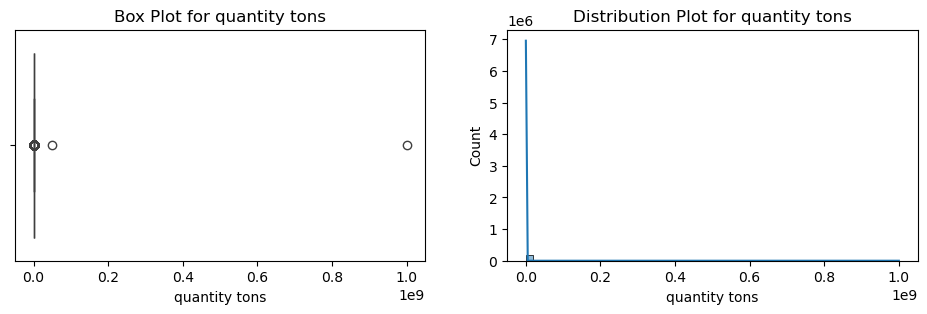

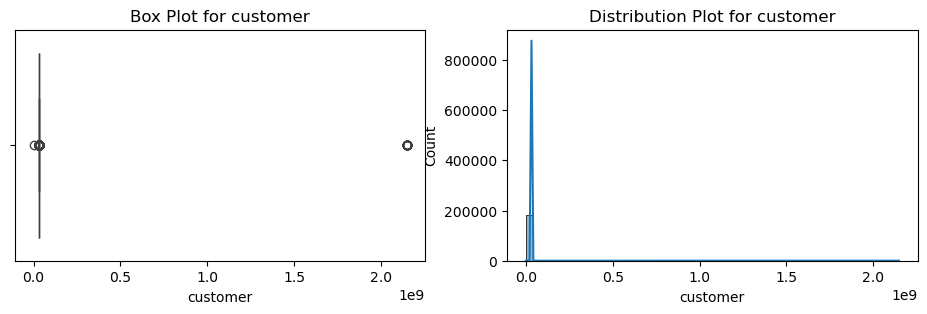

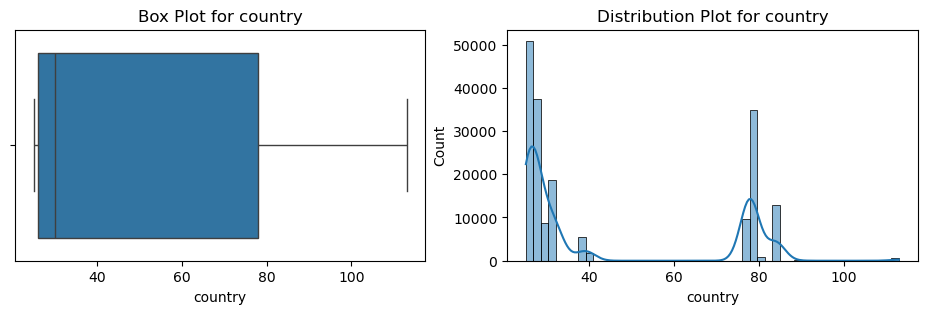

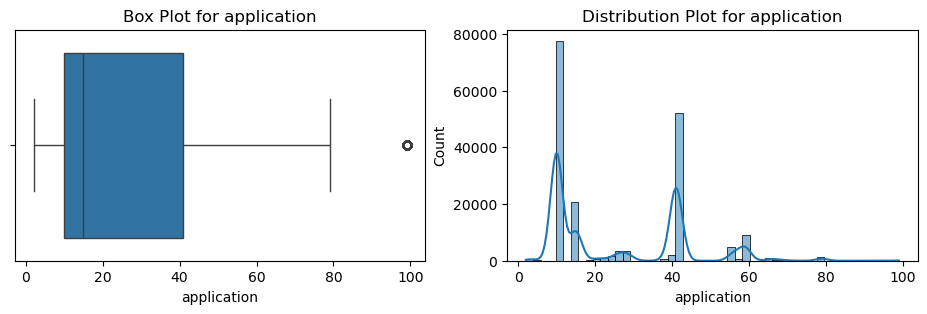

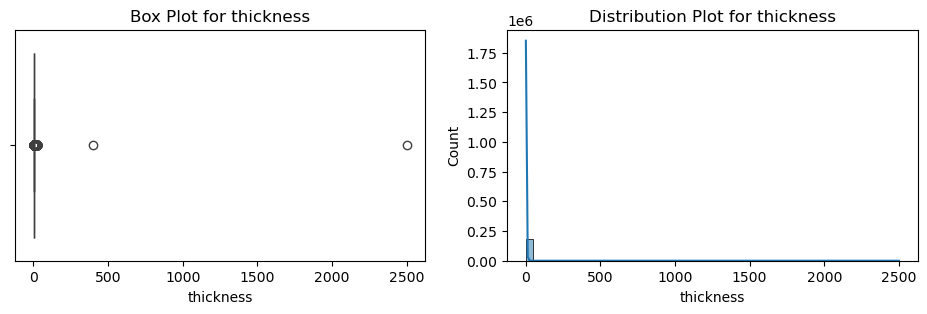

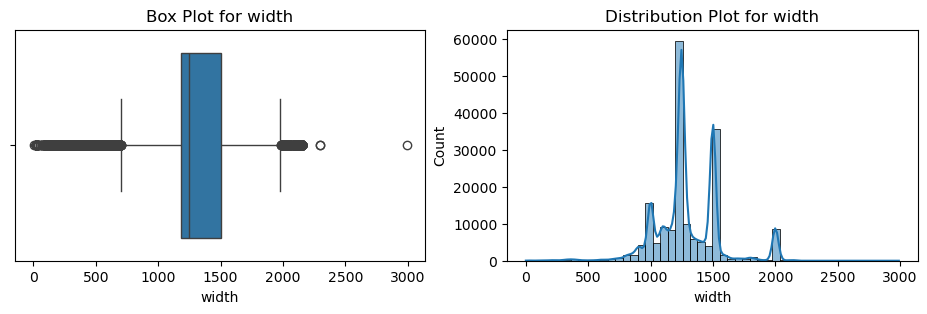

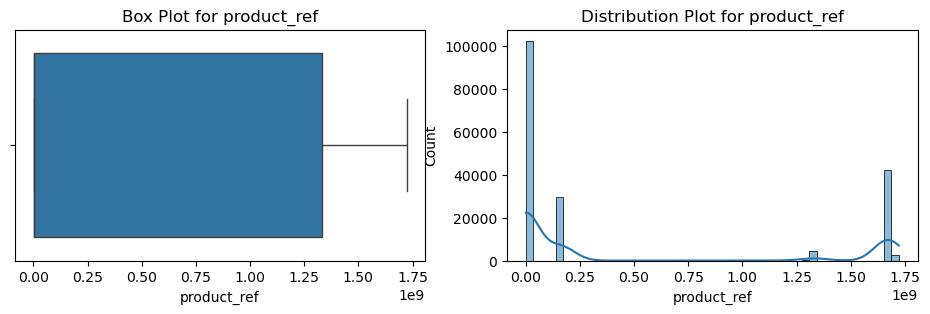

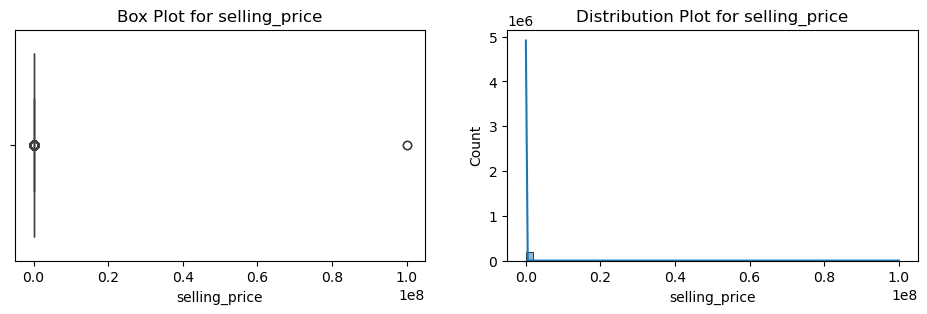

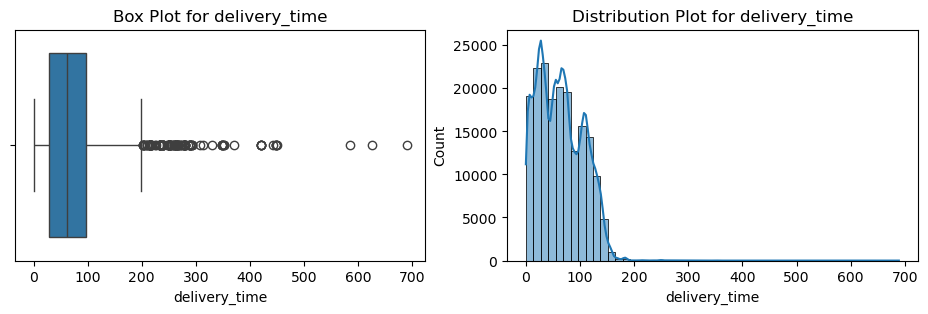

In [23]:
# Visualise these values with plots - box and hist:

def plot(df, column):
    plt.figure(figsize=(18,3))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')
    plt.show()

for col in numeric_columns:
    plot(out_copp, col)

### Inference:
The visuals make it clear that, from our skew analysis, the columns of quanntity tons, thickness and selling_price are heavily skewed showing positively skewness (with a long right tail)

In [24]:
# there were negative values in the two columns of quantity and selling_price
# we are converting those -ve values to nan, and then removing them from the dataset.
skewed_columns = ['quantity tons', 'thickness', 'selling_price']
for column in skewed_columns:
    neg = (out_copp[column] <= 0)
    print(f'{column} : {neg.sum()} ')
    out_copp.loc[neg,column] = np.nan

quantity tons : 4 
thickness : 0 
selling_price : 7 


In [25]:
out_copp.dropna(inplace=True)

In [26]:
out_copp.isna().sum()

item_date        0
quantity tons    0
customer         0
country          0
status           0
item type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery date    0
selling_price    0
delivery_time    0
dtype: int64

### Choosing the Right Transformation

From the analysis, we figured the 3 columns with high skewness. We will remove the skewness with the below transformations..

* Log Transformation: Use when data is highly positively skewed.
* Square Root Transformation: Use for moderate skewness.
* Box-Cox Transformation: Requires data to be positive; useful for a wide range of skewness.
* Yeo-Johnson Transformation: Useful when data includes zero or negative values.

We will go with the **log transformation** since we see a high positive skew in our data.

In [27]:
# log transformation:
out_copp['quantity_tons_log']=np.log(out_copp['quantity tons'])
out_copp['thickness_log']=np.log(out_copp['thickness'])
out_copp['selling_price_log']=np.log(out_copp['selling_price'])
out_copp.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,delivery_time,quantity_tons_log,thickness_log,selling_price_log
0,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00,91,3.991779,0.693147,6.749931
1,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,DX51D+Z,1668701718,2021-04-01,1047.00,0,6.643822,-0.223144,6.953684
2,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33,90,5.956169,-0.967584,6.468211
3,2021-04-01,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,2021-01-01,768.00,90,5.310301,0.832909,6.643790
4,2021-04-01,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,2021-03-01,577.00,31,6.666354,1.386294,6.357842


In [28]:
out_copp.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,181662,2020-11-26 22:55:58.509760,2020-07-02 00:00:00,2020-09-29 00:00:00,2020-11-30 00:00:00,2021-02-03 00:00:00,2021-04-01 00:00:00,NaN
quantity tons,181662.0,5875.290738,0.00001,10.970879,30.365013,67.161415,1000000000.0,2349145.895941
customer,181662.0,30512226.281704,12458.0,30196884.0,30205242.0,30280416.0,2147483647.0,24334485.222328
country,181662.0,44.898933,25.0,26.0,30.0,78.0,113.0,24.406038
application,181662.0,25.613342,2.0,10.0,15.0,41.0,99.0,17.753943
thickness,181662.0,2.551133,0.18,0.7,1.5,3.0,400.0,2.977116
width,181662.0,1295.289042,1.0,1180.0,1250.0,1500.0,2990.0,261.638547
product_ref,181662.0,473948584.656709,611728.0,611993.0,640665.0,1332077137.0,1722207579.0,717503310.723785
delivery date,181662,2021-01-25 22:43:27.048254464,2019-04-01 00:00:00,2020-11-01 00:00:00,2021-01-01 00:00:00,2021-04-01 00:00:00,2022-01-01 00:00:00,NaN
selling_price,181662.0,1918.15583,0.1,669.0,812.0,953.0,100001015.0,331804.774316


In [29]:
# removing those columns with skewness:
out_copp.drop(columns=['quantity tons','thickness','selling_price'], inplace=True)

In [30]:
# Outliers handle with IQR and cliping method 

def outlier(df, column):
    # IQR = Q3 - Q1
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

# Using the function created to handle outliers in our dataset:
outlier(out_copp,'quantity_tons_log')
outlier(out_copp,'thickness_log')
outlier(out_copp,'selling_price_log')
outlier(out_copp,'width')

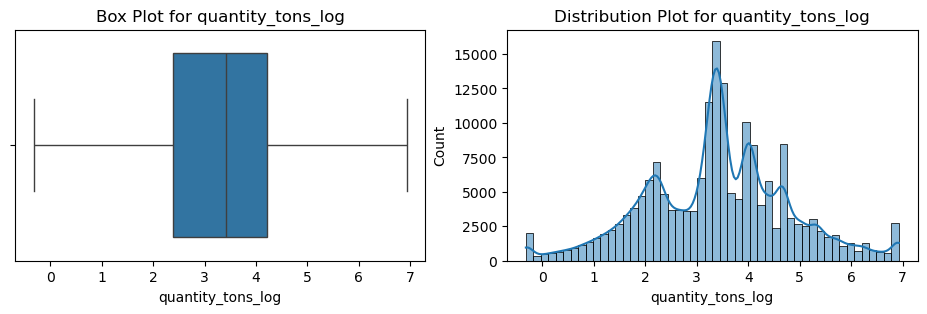

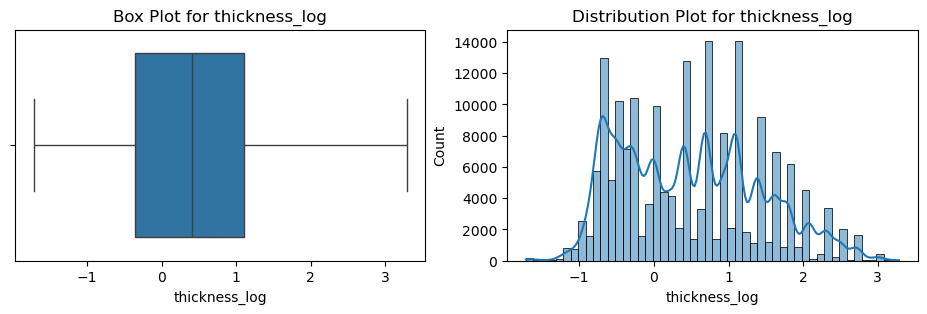

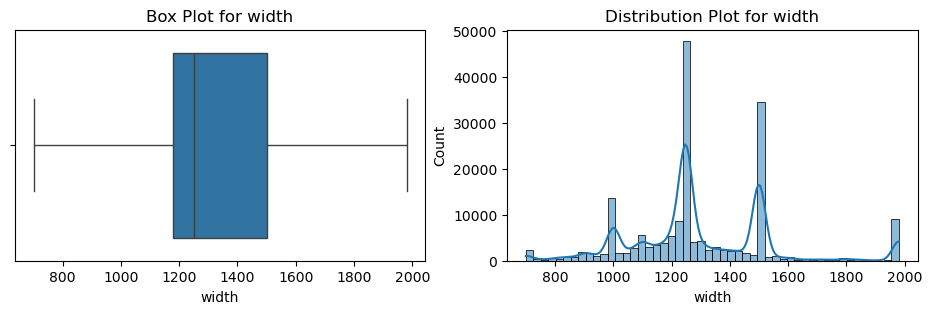

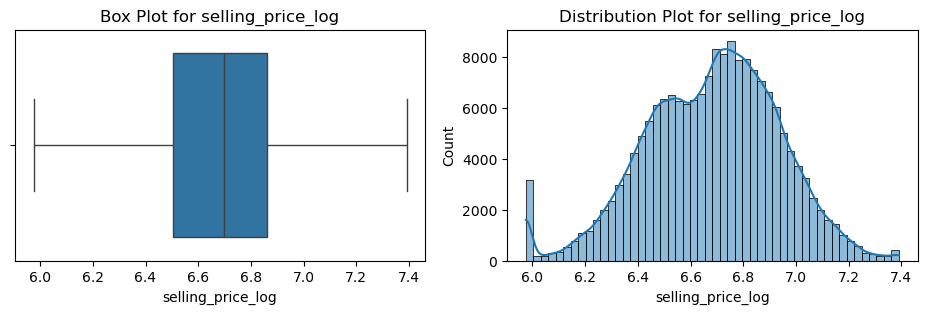

In [31]:
# Plotting after skew and outliers 

new_cols = ['quantity_tons_log', 'thickness_log', 'width', 'selling_price_log']
for col in new_cols:
    plot(out_copp, col)
    
# all seem to show a normally distributed values now after the skewness and outlier treatment.

## Feature Engineering
Here, we are going to do a few things that facilitate modelling:

* *Correlation* - We will drop highly related fields which makes our modelling robust.
* *Encoding* - By this way, we can make use of categorical values for our modelling.

### Correlation - with heatmap

In [32]:
# copy of out_copp:
mod_copp = out_copp.copy(True)

In [33]:
mod_copp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181662 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   item_date          181662 non-null  datetime64[ns]
 1   customer           181662 non-null  float64       
 2   country            181662 non-null  float64       
 3   status             181662 non-null  object        
 4   item type          181662 non-null  object        
 5   application        181662 non-null  float64       
 6   width              181662 non-null  float64       
 7   material_ref       181662 non-null  object        
 8   product_ref        181662 non-null  int64         
 9   delivery date      181662 non-null  datetime64[ns]
 10  delivery_time      181662 non-null  int64         
 11  quantity_tons_log  181662 non-null  float64       
 12  thickness_log      181662 non-null  float64       
 13  selling_price_log  181662 non-null  float64      

<Axes: >

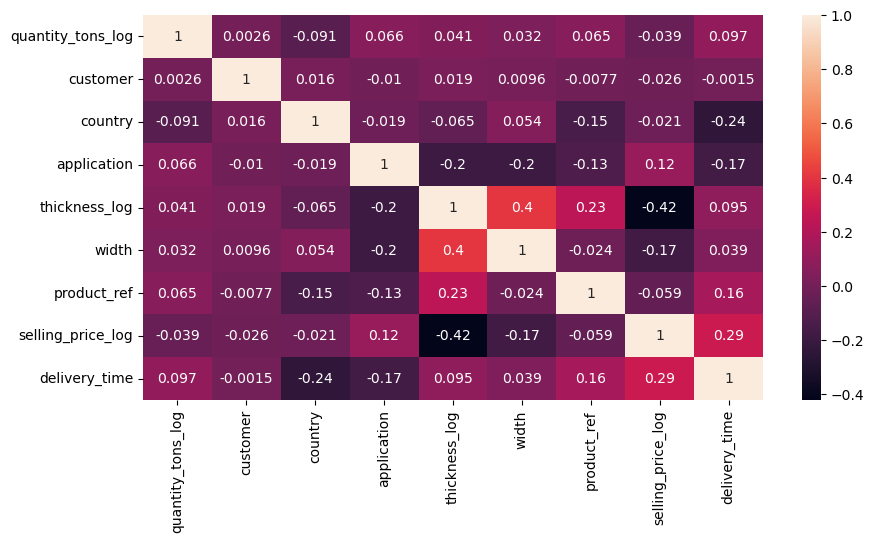

In [34]:
corr = mod_copp[['quantity_tons_log', 'customer', 'country', 'application', 'thickness_log', 'width','product_ref', 'selling_price_log','delivery_time']].corr()

plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)

### Encoding categorical fields:

In [35]:
mod_copp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181662 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   item_date          181662 non-null  datetime64[ns]
 1   customer           181662 non-null  float64       
 2   country            181662 non-null  float64       
 3   status             181662 non-null  object        
 4   item type          181662 non-null  object        
 5   application        181662 non-null  float64       
 6   width              181662 non-null  float64       
 7   material_ref       181662 non-null  object        
 8   product_ref        181662 non-null  int64         
 9   delivery date      181662 non-null  datetime64[ns]
 10  delivery_time      181662 non-null  int64         
 11  quantity_tons_log  181662 non-null  float64       
 12  thickness_log      181662 non-null  float64       
 13  selling_price_log  181662 non-null  float64      

In [36]:
# taking the status field and seeing the value counts:
mod_copp['status'].value_counts()

status
Won                116004
Lost                34438
Not lost for AM     19571
Revised              4276
To be approved       4170
Draft                3139
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64

In [37]:
# Using map function, we are encoding the values for the status column which we will be using for the classification model:

mod_copp['status']= mod_copp['status'].map({'Won':1, 'Draft':2, 'To be approved':3, 'Lost':0, 'Not lost for AM':4,
                                'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8})
mod_copp['status'].unique()

array([1, 2, 3, 0, 4, 5, 6, 7, 8], dtype=int64)

In [38]:
# using ordinal encoder to encode the values in item type column

mod_copp["item type"]= OrdinalEncoder().fit_transform(mod_copp[["item type"]])
mod_copp['item type'].unique()

array([5., 6., 3., 1., 2., 0., 4.])

In [39]:
mod_copp['country'].value_counts()

country
78.0     32111
26.0     27515
25.0     23358
27.0     21508
32.0     18657
28.0     15824
84.0     12776
77.0      9714
30.0      8701
39.0      3731
79.0      2742
38.0      1712
40.0      1683
80.0       819
113.0      714
89.0        92
107.0        5
Name: count, dtype: int64

In [40]:
# using ordinal encoder to encode the values in country column

mod_copp['country']= OrdinalEncoder().fit_transform(mod_copp[['country']])
mod_copp['country'].unique()

array([ 3.,  0.,  4.,  5.,  6., 10.,  2.,  9., 16., 11.,  1.,  7.,  8.,
       13., 12., 15., 14.])

In [73]:
mod_copp['country'].value_counts()

country
10.0    32111
1.0     27515
0.0     23358
2.0     21508
5.0     18657
3.0     15824
13.0    12776
9.0      9714
4.0      8701
7.0      3731
11.0     2742
6.0      1712
8.0      1683
12.0      819
16.0      714
14.0       92
15.0        5
Name: count, dtype: int64

In [41]:
mod_copp.head(2)

,item_date,customer,country,status,item type,application,width,material_ref,product_ref,delivery date,delivery_time,quantity_tons_log,thickness_log,selling_price_log
0,2021-04-01,30156308.0,3.0,1,5.0,10.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,91,3.991779,0.693147,6.749931
1,2021-04-01,30202938.0,0.0,1,5.0,41.0,1210.0,DX51D+Z,1668701718,2021-04-01,0,6.643822,-0.223144,6.953684


In [42]:
out_copp.head(2)

,item_date,customer,country,status,item type,application,width,material_ref,product_ref,delivery date,delivery_time,quantity_tons_log,thickness_log,selling_price_log
0,2021-04-01,30156308.0,28.0,Won,W,10.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,91,3.991779,0.693147,6.749931
1,2021-04-01,30202938.0,25.0,Won,W,41.0,1210.0,DX51D+Z,1668701718,2021-04-01,0,6.643822,-0.223144,6.953684


## Model Building:

### Regression model - Selling price prediction:
Firstly, we will work on a model to predict the selling price of the copper. Since being a continuous variable, the probably technique would be a linear regression or other regressor models. We will compare the performance of all and then decide on the best one.

In [43]:
copp_df = mod_copp.copy(True)

In [44]:
# we are taking the required columns for x and y:
X = copp_df.drop(columns=['selling_price_log','item_date','delivery date','material_ref'],axis=1)
y = copp_df['selling_price_log']

In [45]:
# split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

### Models of choice for regression to predict selling price:
We will be using 4 regression models here: *Random Forest Regressor, Extra Trees Regressor, Extreme Gradient Boosting Regressor, Decision Tree Regressor*. With the knowledge that since there is much linearity in the data, we are not testing out the linear regression model for this particular data and are going with tree based regressor models

In [46]:
# Create an instance of each regression model
rand_model = RandomForestRegressor()
et_model = ExtraTreesRegressor()
xgb_model = XGBRegressor()
dt_model = DecisionTreeRegressor()

### Running through each of the 4 models:

In [47]:
# 1. Random forest regressor:
rand_model.fit(X_train, y_train)
rand_preds = rand_model.predict(X_test) # make predictions
# Evaluate the model performance:
rand_mse = mean_squared_error(y_test, rand_preds)
rand_mae = mean_absolute_error(y_test, rand_preds)
rand_r2 = r2_score(y_test, rand_preds)

In [48]:
# 2. Extra Trees Regressor:
et_model.fit(X_train, y_train)
et_preds = et_model.predict(X_test)
et_mse = mean_squared_error(y_test, et_preds)
et_mae = mean_absolute_error(y_test, et_preds)
et_r2 = r2_score(y_test, et_preds)

In [49]:
# 3. XGBoost Regressor:
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

In [50]:
# 4. Decision Tree Regressor:
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_preds)
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)

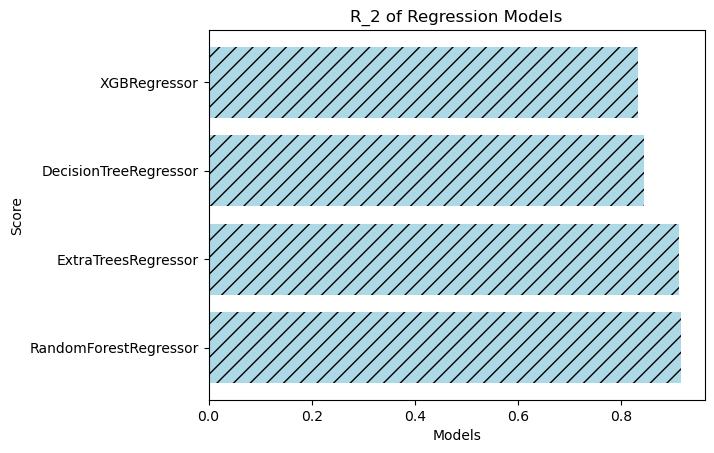

FINDING BEST FIT MODEL FOR EVALUATION BASED ON R_2 SCORE

RandomForestRegressor 0.9162343535759953
ExtraTreesRegressor 0.9122554845052274
DecisionTreeRegressor 0.8435059013019196
XGBRegressor 0.8320933148168221

Best Model: RandomForestRegressor contain Maximum R2_Score: 0.9162343535759953 


In [51]:
# Finding the best model based on the R2 score:

models = ['RandomForestRegressor','ExtraTreesRegressor', 'DecisionTreeRegressor', 'XGBRegressor']
score = [rand_r2, et_r2, dt_r2, xgb_r2]

plt.barh(models, score, color='lightblue',hatch='//')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('R_2 of Regression Models')
plt.show()

print("FINDING BEST FIT MODEL FOR EVALUATION BASED ON R_2 SCORE\n")
max_score = max(score)  # Initialize max_score with the maximum value in the score list
max_model = ""

for model, score_value in zip(models, score):
    print(model, score_value)
    if score_value == max_score:
        max_model = model

print(f"\nBest Model: {max_model} contain Maximum R2_Score: {max_score} ")

### Hyperparameter tuning for Random forest :
https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

Let’s use **GridSearchCV** to obtain the best parameters for the model. For that, we will pass RandomFoestClassifier() instance to the model and then fit the GridSearchCV using the training data to find the best parameters.

**# mentioning the parameter tunings:**
param_grid = { 
    'n_estimators' :[100,170],
    'max_depth': [10,30],     
    'min_samples_split': [2,6], 
    'min_samples_leaf': [1,3],
    'max_features'    : ['sqrt', 'log2', None] }


grid_srh_cv = GridSearchCV(estimator=RandomForestRegressor(),
                            param_grid=param_grid, cv=3, n_jobs=-1)
grid_srh_cv.fit(X_train, y_train)

grid_srh_cv.best_params_, grid_srh_cv.best_score_

**# Random forest model based on tunings made:**
rf_model_v1 = RandomForestRegressor()
rf_model_v1.fit(X_train, y_train)
rf_preds = rf_model_v1.predict(X_test) # make predictions

**# Evaluate the model performance:**
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

In [52]:
# finalising the model:
model = rand_model.fit(X_train, y_train)

# creating a pickle file of that:
file_path='RandomForestRegressor.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model, file)
print(f'Pickle file created: {file_path}')

Pickle file created: RandomForestRegressor.pkl


In [53]:
et_model = et_model.fit(X_train, y_train)
xgb_model = xgb_model.fit(X_train, y_train)
dt_model = dt_model.fit(X_train, y_train)

# pickling all the models:
file_path1='ExtraTreesRegressor.pkl'
with open(file_path1, 'wb') as file:
    pickle.dump(et_model, file)
print(f'Pickle file created: {file_path1}')

file_path2='XGBRegressor.pkl'
with open(file_path2, 'wb') as file:
    pickle.dump(xgb_model, file)
print(f'Pickle file created: {file_path2}')

file_path3='DecisionTreeRegressor.pkl'
with open(file_path3, 'wb') as file:
    pickle.dump(dt_model, file)
print(f'Pickle file created: {file_path3}')

Pickle file created: ExtraTreesRegressor.pkl
Pickle file created: XGBRegressor.pkl
Pickle file created: DecisionTreeRegressor.pkl


product_ref          0.290417
delivery_time        0.241297
status               0.168791
country              0.070731
customer             0.067243
quantity_tons_log    0.050588
thickness_log        0.047242
application          0.023598
width                0.020570
item type            0.019522
dtype: float64


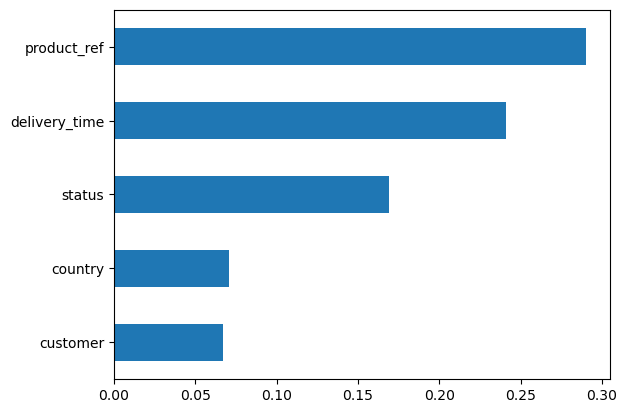

In [54]:
#checkig the features scores and importants

feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

# visualising the important features:
feature_scores.nlargest(5).plot(kind='barh').invert_yaxis()

In [55]:
# load the file and try to predict the value:
with open('RandomForestRegressor.pkl','rb') as files:
    predict_model=pickle.load(files)

pre=predict_model.predict(np.array([[30156308.0,28.0,1,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147]]))
print("Predicted selling price: ",np.exp(pre[0]))

Predicted selling price:  923.7958044656759


###  Classification model - Predicting the status:
When coming to predicting the classification of the status, we are using 3 classification models:

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

In [57]:
# Filter out the values (won|lost) in status column

copp_df_s = copp_df[(copp_df.status==1)|(copp_df.status==0)]
copp_df_s

,item_date,customer,country,status,item type,application,width,material_ref,product_ref,delivery date,delivery_time,quantity_tons_log,thickness_log,selling_price_log
0,2021-04-01,30156308.0,3.0,1,5.0,10.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,91,3.991779,0.693147,6.749931
1,2021-04-01,30202938.0,0.0,1,5.0,41.0,1210.0,DX51D+Z,1668701718,2021-04-01,0,6.643822,-0.223144,6.953684
2,2021-04-01,30153963.0,4.0,1,6.0,28.0,952.0,S0380700,628377,2021-01-01,90,5.956169,-0.967584,6.468211
3,2021-04-01,30349574.0,5.0,1,3.0,59.0,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,2021-01-01,90,5.310301,0.832909,6.643790
4,2021-04-01,30211560.0,3.0,1,5.0,10.0,1980.0,2_S275JR+AR-CL1,640665,2021-03-01,31,6.666354,1.386294,6.357842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181667,2020-07-02,30200854.0,0.0,1,5.0,41.0,1240.0,DX51D+Z,164141591,2020-07-01,1,4.670802,-0.040822,6.400257
181668,2020-07-02,30200854.0,0.0,1,5.0,41.0,1220.0,DX51D+Z,164141591,2020-07-01,1,4.629691,-0.040822,6.381816
181669,2020-07-02,30200854.0,0.0,1,5.0,41.0,1500.0,DX51D+Z,164141591,2020-07-01,1,5.337954,-0.051293,6.378426
181670,2020-07-02,30200854.0,0.0,1,5.0,41.0,1250.0,DX51D+Z,164141591,2020-07-01,1,1.443523,-0.342490,6.428105


In [58]:
copp_df_s['status'].value_counts()

status
1    116004
0     34438
Name: count, dtype: int64

### Synthetic imputting:
Since we are on a classifier model prediction, we should ensure that the categories are closer in percentage in the dataset. If not, like in our case, we should be doing synthetic data imputting of either *oversampling or undersampling*. 

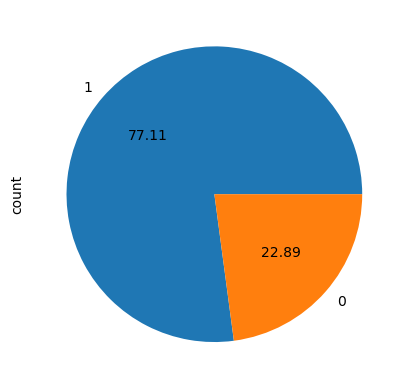

In [59]:
# Looking at the percentage of data present in the status column:
perc_status = copp_df_s['status'].value_counts().plot.pie(autopct='%.2f')

Text(0.5, 1.0, 'over oversampling using smote')

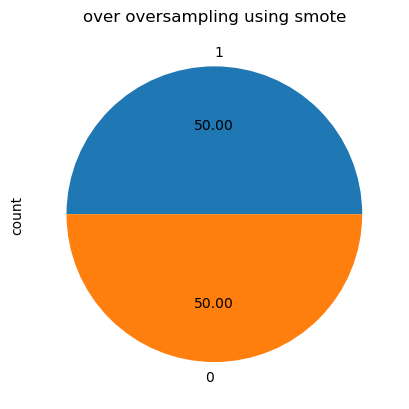

In [60]:
# oversampling the data with SMOTE:
X = copp_df_s.drop(columns = ['status','item_date','delivery date','material_ref'],axis=1)
y = copp_df_s['status']

smote= SMOTE()

X_smote, y_smote = smote.fit_resample(X,y) 

sm = y_smote.value_counts().plot.pie(autopct='%.2f')
sm.set_title('over oversampling using smote')

In [61]:
# classifier model:

# train test split from the dataset where smote was applied:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=5)

In [62]:
# Create instances of each classification model

# random forest:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train) # train model
rfc_preds = rfc_model.predict(X_test) # make predictions on the test
# evaluate with metrics
rfc_accuracy = accuracy_score(y_test, rfc_preds)
rfc_precision = metrics.precision_score(y_test, rfc_preds)
rfc_recall = metrics.recall_score(y_test, rfc_preds)
rfc_f1 = metrics.f1_score(y_test, rfc_preds)


In [64]:
# Extra Trees Classification model:
etc_model = ExtraTreesClassifier()
etc_model.fit(X_train, y_train)
etc_preds = etc_model.predict(X_test)
# evaluation metrics:
etc_accuracy = accuracy_score(y_test, etc_preds)
etc_precision = metrics.precision_score(y_test, etc_preds)
etc_recall = metrics.recall_score(y_test, etc_preds)
etc_f1 = metrics.f1_score(y_test, etc_preds)

In [65]:
# XGBoost Classifier model:
xgbc_model = xgb.XGBClassifier()
xgbc_model.fit(X_train, y_train)
xgbc_preds = xgbc_model.predict(X_test)
# model evaluation metrics:
xgbc_accuracy = accuracy_score(y_test, xgbc_preds)
xgbc_precision = metrics.precision_score(y_test, xgbc_preds)
xgbc_recall = metrics.recall_score(y_test, xgbc_preds)
xgbc_f1 = metrics.f1_score(y_test, xgbc_preds)

In [66]:
# Accuracy scores of all the models:
print('All model accuracies :\n')
print('Random Forest Accuracy: ', rfc_accuracy)
print('Extra Trees Accuracy: ',etc_accuracy)
print('XGBoost Accuracy: ', xgbc_accuracy)

All model accuracies :

Random Forest Accuracy:  0.9749148743588638
Extra Trees Accuracy:  0.9781331264456992
XGBoost Accuracy:  0.9312673304311596


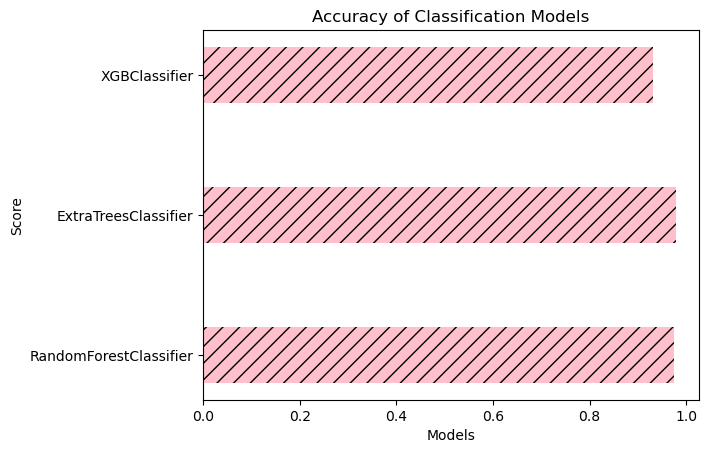

FINDING BEST FIT MODEL FOR EVALUATION BASED ON  ACCURACY:

RandomForestClassifier 0.9749148743588638
ExtraTreesClassifier 0.9781331264456992
XGBClassifier 0.9312673304311596

Best Model: ExtraTreesClassifier contains Maximum accuracy: 0.9781331264456992 


In [67]:
models = ['RandomForestClassifier', 'ExtraTreesClassifier', 'XGBClassifier']
score = [rfc_accuracy, etc_accuracy, xgbc_accuracy]

plt.barh(models, score, color='pink', height=0.4, hatch='//')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Accuracy of Classification Models')
plt.show()

print("FINDING BEST FIT MODEL FOR EVALUATION BASED ON  ACCURACY:\n")
max_score = max(score)  # Initialize max_score with the maximum value in the score list
max_model = ""

for model, score_value in zip(models, score):
    print(model, score_value)
    if score_value == max_score:
        max_model = model

print(f"\nBest Model: {max_model} contains Maximum accuracy: {max_score} ")

In [68]:
# saving and pickling the model:
model_etc = etc_model.fit(X_train, y_train)

file_path4='ExtraTreesClassifier.pkl'
with open(file_path4, 'wb') as file:
    pickle.dump(model_etc, file)
print(f'Pickle file created: {file_path4}')

Pickle file created: ExtraTreesClassifier.pkl


In [69]:
# evaluation metrics
print(metrics.confusion_matrix(y_test,etc_preds))
print(metrics.classification_report(y_test,etc_preds))

[[34563   396]
 [ 1126 33518]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     34959
           1       0.99      0.97      0.98     34644

    accuracy                           0.98     69603
   macro avg       0.98      0.98      0.98     69603
weighted avg       0.98      0.98      0.98     69603



In [70]:
#checkig the features scores and importants

feature_scores = pd.Series(model_etc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

delivery_time        0.182298
customer             0.128762
country              0.115873
item type            0.115555
quantity_tons_log    0.097738
application          0.095101
selling_price_log    0.086667
thickness_log        0.066530
product_ref          0.063435
width                0.048041
dtype: float64

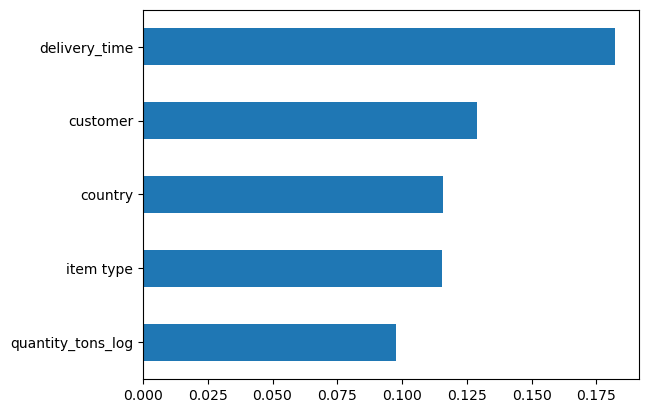

In [71]:
# visualising the important features:
feature_scores.nlargest(5).plot(kind='barh').invert_yaxis()

In [74]:
# load the pickle and predict the status with classifier model

with open('ExtraTreesClassifier.pkl','rb') as files:
    model_et_cls=pickle.load(files)

etc = model_et_cls.predict( np.array([[30156308.0,1.0,5.0,10.0,1500.0,1670798778,91.0,3.991779,0.693147,6.749931]]))
if etc[0] == 1:
    print('Won')
else:
    print('Lose')

Won


In [77]:
print(rand_mse)
print(et_mse)
print(xgb_mse)
print(dt_mse)

0.0054660005831978515
0.005725635667384972
0.010956496825541838
0.010211785753086459
